## 1. import packages

In [1]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime

/Users/shongmatsuzai/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import warnings
warnings.filterwarnings('ignore')

## 2. read data

Because the "test.csv" doesn't have our target "palytime", I use the "train.csv" as the training data and testing data.
Then I will use "test.csv" to make the output as my submission.

In [3]:
# Read the data.

addr1 = "/Users/shongmatsuzai/Desktop/HKUST-2019fall/MSBD5001/Kaggle-InClass Prediction Competition/data/train.csv"
addr2 = "/Users/shongmatsuzai/Desktop/HKUST-2019fall/MSBD5001/Kaggle-InClass Prediction Competition/data/test.csv"
train = pd.read_csv(addr1)
test = pd.read_csv(addr2)

## 3. initial data information

In [4]:
# data information of games

print(train.info())
print(train.shape)
print(train.columns)
print(train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 11 columns):
id                        357 non-null int64
playtime_forever          357 non-null float64
is_free                   357 non-null bool
price                     357 non-null float64
genres                    357 non-null object
categories                357 non-null object
tags                      357 non-null object
purchase_date             355 non-null object
release_date              357 non-null object
total_positive_reviews    355 non-null float64
total_negative_reviews    355 non-null float64
dtypes: bool(1), float64(4), int64(1), object(5)
memory usage: 28.3+ KB
None
(357, 11)
Index(['id', 'playtime_forever', 'is_free', 'price', 'genres', 'categories',
       'tags', 'purchase_date', 'release_date', 'total_positive_reviews',
       'total_negative_reviews'],
      dtype='object')
id                        0
playtime_forever          0
is_free                   0
price     

In [5]:
train['playtime_forever'].describe()

count    357.000000
mean       3.119234
std       11.213114
min        0.000000
25%        0.000000
50%        0.083333
75%        1.616667
max      113.800000
Name: playtime_forever, dtype: float64

In [6]:
# data information of games_sub

print(test.info())
print(test.columns)
print(test.shape)
print(test.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 10 columns):
id                        90 non-null int64
is_free                   90 non-null bool
price                     90 non-null int64
genres                    90 non-null object
categories                90 non-null object
tags                      90 non-null object
purchase_date             88 non-null object
release_date              90 non-null object
total_positive_reviews    88 non-null float64
total_negative_reviews    88 non-null float64
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 6.5+ KB
None
Index(['id', 'is_free', 'price', 'genres', 'categories', 'tags',
       'purchase_date', 'release_date', 'total_positive_reviews',
       'total_negative_reviews'],
      dtype='object')
(90, 10)
id                        0
is_free                   0
price                     0
genres                    0
categories                0
tags                      0
purchase_

## 4. data processing

I process dataset to make the data types can fit the model I use.

### 4.1 "is_free"

In [7]:
# column: is_free, transfer it from True/False to 1/0.

train['is_free']=train['is_free'].astype('int')
test['is_free']=test['is_free'].astype('int')

### 4.2 "genres, categories, tags"

In [8]:
# column: genres, categories, tags

# use dummies to separate each string in gerens, categories, tags  

grs_tr = train["genres"].str.get_dummies(",")
grs_te = test["genres"].str.get_dummies(",")

catg_tr = train["categories"].str.get_dummies(",")
catg_te = test["categories"].str.get_dummies(",")

# the number of tags is too big, I decide not to choose tags as a feature.
# tags_tr = train["tags"].str.get_dummies(",")
# tags_te = test["tags"].str.get_dummies(",")

In [9]:
# use map() lambda fuction to change column names

grs_tr.columns = grs_tr.columns.map(lambda x: "grs_"+x)
grs_te.columns = grs_te.columns.map(lambda x: "grs_"+x)

catg_tr.columns = catg_tr.columns.map(lambda x: "catg_"+x)
catg_te.columns = catg_te.columns.map(lambda x: "catg_"+x)

In [10]:
print(grs_tr.columns.shape)
print(grs_te.columns.shape)
print(catg_tr.columns.shape)
print(catg_te.columns.shape)

(20,)
(14,)
(29,)
(28,)


In [11]:
# make dataframe train and test have the same columns except "playtime_forever"

# the difference is from genrens and categories

# find the elements that are only in grs_tr.columns and grs_te.columns

train_grs = set(grs_tr.columns.values.tolist())
test_grs = set(grs_te.columns.values.tolist())

# train_grs1 is the set of elements that are only in test_grs

train_grs1 = test_grs - (train_grs & test_grs)

# test_grs1 is the set of elements that are only in train_grs

test_grs1 = train_grs - (train_grs & test_grs)

print(train_grs1)
print(test_grs1)

set()
{'grs_Utilities', 'grs_Sexual Content', 'grs_Audio Production', 'grs_Animation & Modeling', 'grs_Design & Illustration', 'grs_Racing'}


In [12]:
# train_grs has elements that test_grs doesn't have

# fill the new elements as "0", and then add test_grs1 to "grs_te"

for x in list(test_grs1):
    grs_te[x] = [0 for i in range(90)]
grs_te.shape

(90, 20)

In [13]:
# find the elements that are only in catg_tr.columns and catg_te.columns

train_catg = set(catg_tr.columns.values.tolist())
test_catg = set(catg_te.columns.values.tolist())

# train_catg1 is the set of elements that are only in test_catg

train_catg1 = test_catg - (train_catg & test_catg)

#  test_catg1 is the set of elements that are only in train_catg
test_catg1 = train_catg - (train_catg & test_catg)

print(train_catg1)
print(test_catg1)

set()
{'catg_Valve Anti-Cheat enabled'}


In [14]:
# train_catg has elements that test_catg doesn't have

# fill the new elements as "0", and then add test_catg1 to "catg_te"

for x in list(test_catg1):
    catg_te[x] = [0 for i in range(90)]
catg_te.shape

(90, 29)

In [15]:
# delete columns "genres, categories, tags"

train.drop(['genres', 'categories', 'tags'], axis=1, inplace=True)    
test.drop(['genres', 'categories', 'tags'], axis=1, inplace=True)  

In [16]:
print(train.shape)
print(test.shape)

(357, 8)
(90, 7)


In [17]:
# merge the dataframe train/test and dataframe grs_tr/grs_te, catg_tr/catg_te, tags_tr/tags_te together

train = pd.concat([train, grs_tr, catg_tr], axis =1)
test = pd.concat([test, grs_te, catg_te], axis =1)

#train = pd.concat([train, grs_tr], axis =1)
#test = pd.concat([test, grs_te], axis =1)

In [18]:
train.shape

(357, 57)

In [19]:
test.shape

(90, 56)

In [20]:
train.head()

,id,playtime_forever,is_free,price,purchase_date,release_date,total_positive_reviews,total_negative_reviews,grs_Action,grs_Adventure,...,catg_Single-player,catg_Stats,catg_Steam Achievements,catg_Steam Cloud,catg_Steam Leaderboards,catg_Steam Trading Cards,catg_Steam Workshop,catg_SteamVR Collectibles,catg_VR Support,catg_Valve Anti-Cheat enabled
0,0,0.000000,0,3700.0,"Jul 2, 2018","10 Dec, 2013",372.0,96.0,0,1,...,1,0,0,1,0,1,0,0,0,0
1,1,0.016667,1,0.0,"Nov 26, 2016","12 Aug, 2015",23.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2,0.000000,0,5000.0,"Jul 2, 2018","28 Jan, 2014",3018.0,663.0,0,1,...,1,0,0,1,0,1,0,0,0,0
3,3,1.533333,0,9900.0,"Nov 28, 2016","31 Mar, 2010",63078.0,1746.0,1,0,...,1,0,1,0,0,1,1,0,0,0
4,4,22.333333,0,4800.0,"Mar 4, 2018","30 Jul, 2012",8841.0,523.0,1,0,...,1,0,1,1,1,1,0,0,0,0


In [21]:
test.head()

,id,is_free,price,purchase_date,release_date,total_positive_reviews,total_negative_reviews,grs_Action,grs_Adventure,grs_Casual,...,catg_Single-player,catg_Stats,catg_Steam Achievements,catg_Steam Cloud,catg_Steam Leaderboards,catg_Steam Trading Cards,catg_Steam Workshop,catg_SteamVR Collectibles,catg_VR Support,catg_Valve Anti-Cheat enabled
0,0,0,3500,"Oct 28, 2018",22-May-12,2607.0,1122.0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,11600,"Jul 20, 2019",24-Apr-18,5762.0,2235.0,1,1,0,...,1,0,1,1,0,1,0,0,0,0
2,2,0,2100,"Jul 16, 2019",20-Mar-17,687.0,133.0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
3,3,0,3600,"Jan 30, 2018",17-Jul-07,67.0,39.0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4,0,3400,"Feb 24, 2017",22-Aug-13,40344.0,3708.0,1,1,0,...,1,0,1,1,0,1,1,0,0,0


### 4.3 "purchase_date, release_date"

In [22]:
# column: purchase_date，release_date 

# transfer date columns to datetime type

train['purchase_date'] = pd.to_datetime(train['purchase_date'])
train['release_date'] = pd.to_datetime(train['release_date'])
test['purchase_date'] = pd.to_datetime(test['purchase_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [23]:
# find the loction of null

train[train.isnull().T.any()]

,id,playtime_forever,is_free,price,purchase_date,release_date,total_positive_reviews,total_negative_reviews,grs_Action,grs_Adventure,...,catg_Single-player,catg_Stats,catg_Steam Achievements,catg_Steam Cloud,catg_Steam Leaderboards,catg_Steam Trading Cards,catg_Steam Workshop,catg_SteamVR Collectibles,catg_VR Support,catg_Valve Anti-Cheat enabled
5,5,2.933333,0,25800.0,NaT,2019-03-26,NaN,NaN,0,0,...,1,1,1,0,0,1,0,0,0,0
76,76,0.000000,0,4800.0,NaT,2011-08-16,NaN,NaN,1,0,...,1,0,1,1,1,1,0,0,0,0


In [24]:
test[test.isnull().T.any()]

,id,is_free,price,purchase_date,release_date,total_positive_reviews,total_negative_reviews,grs_Action,grs_Adventure,grs_Casual,...,catg_Single-player,catg_Stats,catg_Steam Achievements,catg_Steam Cloud,catg_Steam Leaderboards,catg_Steam Trading Cards,catg_Steam Workshop,catg_SteamVR Collectibles,catg_VR Support,catg_Valve Anti-Cheat enabled
12,12,0,4800,NaT,2016-02-24,NaN,NaN,1,1,0,...,1,0,1,1,0,1,0,0,0,0
45,45,0,7000,NaT,2017-02-16,NaN,NaN,0,1,0,...,1,0,1,1,0,0,0,0,0,0


In [25]:
# calculate the days between release_date and purchase_date

# check whether all the outcomes make sense

days_RelPur1 = (train['purchase_date'] - train['release_date']).astype(int)
print(days_RelPur1.values.all()>0)

False


In [26]:
days_RelPur2 = (test['purchase_date'] - test['release_date']).astype(int)
print(days_RelPur2.values.all()>0)

False


In [27]:
def RelPur(x):
    
    for i, row in x.iterrows():
        days_RelPur = (row['purchase_date'] - row['release_date'])
        # exchange the location of purchase_date and release_date if purchase_date < release_date
        if days_RelPur.days < 0:
            t = row['purchase_date']
            x.loc[i,'purchase_date'] = row['release_date']
            x.loc[i,'release_date'] = t 
        x.loc[i, 'days_RelPur'] = (row['purchase_date'] - row['release_date']).days
        # calulate the mean of days_RelPur
        days_RelPur_mean = datetime.timedelta(days=(x['purchase_date'] - x['release_date']).mean().days)
        # give the mean of days_RelPur to the rows that "purchase_date" is null
        if str(row['purchase_date']) == 'NaT':
            x.loc[i, 'days_RelPur'] = days_RelPur_mean.days
    
    return x.head(10)
        
    


In [28]:
RelPur(train)

,id,playtime_forever,is_free,price,purchase_date,release_date,total_positive_reviews,total_negative_reviews,grs_Action,grs_Adventure,...,catg_Stats,catg_Steam Achievements,catg_Steam Cloud,catg_Steam Leaderboards,catg_Steam Trading Cards,catg_Steam Workshop,catg_SteamVR Collectibles,catg_VR Support,catg_Valve Anti-Cheat enabled,days_RelPur
0,0,0.000000,0,3700.0,2018-07-02,2013-12-10,372.0,96.0,0,1,...,0,0,1,0,1,0,0,0,0,1665.0
1,1,0.016667,1,0.0,2016-11-26,2015-08-12,23.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,472.0
2,2,0.000000,0,5000.0,2018-07-02,2014-01-28,3018.0,663.0,0,1,...,0,0,1,0,1,0,0,0,0,1616.0
3,3,1.533333,0,9900.0,2016-11-28,2010-03-31,63078.0,1746.0,1,0,...,0,1,0,0,1,1,0,0,0,2434.0
4,4,22.333333,0,4800.0,2018-03-04,2012-07-30,8841.0,523.0,1,0,...,0,1,1,1,1,0,0,0,0,2043.0
5,5,2.933333,0,25800.0,NaT,2019-03-26,NaN,NaN,0,0,...,1,1,0,0,1,0,0,0,0,1006.0
6,6,2.616667,0,3600.0,2018-02-16,2012-10-23,39776.0,1035.0,1,0,...,0,1,0,0,1,0,0,0,0,1942.0
7,7,0.150000,1,0.0,2018-01-29,2016-04-28,33.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,641.0
8,8,0.016667,0,4000.0,2018-11-23,2014-02-25,1875.0,39.0,0,1,...,0,1,1,0,1,0,0,0,0,1732.0
9,9,0.016667,0,8800.0,2017-12-22,2017-10-17,47.0,11.0,1,1,...,0,1,1,0,0,0,1,0,0,66.0


In [29]:
RelPur(test)

,id,is_free,price,purchase_date,release_date,total_positive_reviews,total_negative_reviews,grs_Action,grs_Adventure,grs_Casual,...,catg_Stats,catg_Steam Achievements,catg_Steam Cloud,catg_Steam Leaderboards,catg_Steam Trading Cards,catg_Steam Workshop,catg_SteamVR Collectibles,catg_VR Support,catg_Valve Anti-Cheat enabled,days_RelPur
0,0,0,3500,2018-10-28,2012-05-22,2607.0,1122.0,1,1,0,...,0,0,0,0,0,0,0,0,0,2350.0
1,1,0,11600,2019-07-20,2018-04-24,5762.0,2235.0,1,1,0,...,0,1,1,0,1,0,0,0,0,452.0
2,2,0,2100,2019-07-16,2017-03-20,687.0,133.0,0,0,0,...,0,1,0,0,1,0,0,0,0,848.0
3,3,0,3600,2018-01-30,2007-07-17,67.0,39.0,1,0,0,...,0,0,0,0,0,0,0,0,0,3850.0
4,4,0,3400,2017-02-24,2013-08-22,40344.0,3708.0,1,1,0,...,0,1,1,0,1,1,0,0,0,1282.0
5,5,0,6800,2018-06-03,2018-02-28,387.0,81.0,0,1,0,...,0,1,1,0,1,0,0,0,0,95.0
6,6,0,6800,2019-06-09,2017-09-12,1628.0,360.0,1,0,1,...,0,1,0,1,1,1,0,0,0,635.0
7,7,0,1800,2018-03-22,2008-06-13,256.0,83.0,1,1,0,...,0,0,0,0,0,0,0,0,0,3569.0
8,8,0,6800,2018-06-12,2011-02-03,1773.0,1290.0,0,0,0,...,0,1,1,0,1,0,0,0,0,2686.0
9,9,0,2999,2016-11-03,2014-03-31,3872.0,1006.0,0,0,0,...,0,1,1,0,1,1,0,0,0,948.0


In [30]:
# calculate the days between purchase_date and the start date of our competition

CompDate = datetime.datetime(2019,9,30)

#check whether all the ourcomes make sense

days_PurComp1 = (CompDate - train['purchase_date']).astype(int)
#print(days_PurComp1)
print(days_PurComp1.values.all()>0)

True


In [31]:
days_PurComp2 = (CompDate - test['purchase_date']).astype(int)
#print(days_PurComp1)
print(days_PurComp2.values.all()>0)

True


In [32]:
def PurComp(x):
    for i, row in x.iterrows():
        days_PurComp = (CompDate - row['purchase_date'])
        x.loc[i, 'days_PurComp'] = (CompDate - row['purchase_date']).days
        # calulate the mean of days_RelPur
        days_PurComp_mean = datetime.timedelta(days=(CompDate - x['purchase_date']).mean().days)
        # give the mean of days_PurComp to the rows that "purchase_date" is null
        if str(row['purchase_date']) == 'NaT':
            x.loc[i, 'days_PurComp'] = days_PurComp_mean.days
            
    return x.head(10)          

In [33]:
PurComp(train)

,id,playtime_forever,is_free,price,purchase_date,release_date,total_positive_reviews,total_negative_reviews,grs_Action,grs_Adventure,...,catg_Steam Achievements,catg_Steam Cloud,catg_Steam Leaderboards,catg_Steam Trading Cards,catg_Steam Workshop,catg_SteamVR Collectibles,catg_VR Support,catg_Valve Anti-Cheat enabled,days_RelPur,days_PurComp
0,0,0.000000,0,3700.0,2018-07-02,2013-12-10,372.0,96.0,0,1,...,0,1,0,1,0,0,0,0,1665.0,455.0
1,1,0.016667,1,0.0,2016-11-26,2015-08-12,23.0,0.0,0,0,...,0,0,0,0,0,0,0,0,472.0,1038.0
2,2,0.000000,0,5000.0,2018-07-02,2014-01-28,3018.0,663.0,0,1,...,0,1,0,1,0,0,0,0,1616.0,455.0
3,3,1.533333,0,9900.0,2016-11-28,2010-03-31,63078.0,1746.0,1,0,...,1,0,0,1,1,0,0,0,2434.0,1036.0
4,4,22.333333,0,4800.0,2018-03-04,2012-07-30,8841.0,523.0,1,0,...,1,1,1,1,0,0,0,0,2043.0,575.0
5,5,2.933333,0,25800.0,NaT,2019-03-26,NaN,NaN,0,0,...,1,0,0,1,0,0,0,0,1006.0,547.0
6,6,2.616667,0,3600.0,2018-02-16,2012-10-23,39776.0,1035.0,1,0,...,1,0,0,1,0,0,0,0,1942.0,591.0
7,7,0.150000,1,0.0,2018-01-29,2016-04-28,33.0,3.0,0,0,...,0,0,0,0,0,0,0,0,641.0,609.0
8,8,0.016667,0,4000.0,2018-11-23,2014-02-25,1875.0,39.0,0,1,...,1,1,0,1,0,0,0,0,1732.0,311.0
9,9,0.016667,0,8800.0,2017-12-22,2017-10-17,47.0,11.0,1,1,...,1,1,0,0,0,1,0,0,66.0,647.0


In [34]:
PurComp(test)

,id,is_free,price,purchase_date,release_date,total_positive_reviews,total_negative_reviews,grs_Action,grs_Adventure,grs_Casual,...,catg_Steam Achievements,catg_Steam Cloud,catg_Steam Leaderboards,catg_Steam Trading Cards,catg_Steam Workshop,catg_SteamVR Collectibles,catg_VR Support,catg_Valve Anti-Cheat enabled,days_RelPur,days_PurComp
0,0,0,3500,2018-10-28,2012-05-22,2607.0,1122.0,1,1,0,...,0,0,0,0,0,0,0,0,2350.0,337.0
1,1,0,11600,2019-07-20,2018-04-24,5762.0,2235.0,1,1,0,...,1,1,0,1,0,0,0,0,452.0,72.0
2,2,0,2100,2019-07-16,2017-03-20,687.0,133.0,0,0,0,...,1,0,0,1,0,0,0,0,848.0,76.0
3,3,0,3600,2018-01-30,2007-07-17,67.0,39.0,1,0,0,...,0,0,0,0,0,0,0,0,3850.0,608.0
4,4,0,3400,2017-02-24,2013-08-22,40344.0,3708.0,1,1,0,...,1,1,0,1,1,0,0,0,1282.0,948.0
5,5,0,6800,2018-06-03,2018-02-28,387.0,81.0,0,1,0,...,1,1,0,1,0,0,0,0,95.0,484.0
6,6,0,6800,2019-06-09,2017-09-12,1628.0,360.0,1,0,1,...,1,0,1,1,1,0,0,0,635.0,113.0
7,7,0,1800,2018-03-22,2008-06-13,256.0,83.0,1,1,0,...,0,0,0,0,0,0,0,0,3569.0,557.0
8,8,0,6800,2018-06-12,2011-02-03,1773.0,1290.0,0,0,0,...,1,1,0,1,0,0,0,0,2686.0,475.0
9,9,0,2999,2016-11-03,2014-03-31,3872.0,1006.0,0,0,0,...,1,1,0,1,1,0,0,0,948.0,1061.0


In [35]:
# transfer the timedelta type to int type, because timedelta can't be used in the model I choose
train['days_RelPur'] = train['days_RelPur'].astype(int)
test['days_RelPur'] = test['days_RelPur'].astype(int)

In [36]:
# delete columns "purchase_date, release_date"

train.drop(['purchase_date','release_date'], axis=1, inplace=True)    
test.drop(['purchase_date','release_date'], axis=1, inplace=True)

### 4.4 "totoal_positive_reviews, total_negative_reviews"

In [37]:
# column: totoal_positive_reviews, total_negative_reviews

# fill the null values with 0

train['total_positive_reviews'].fillna(0, inplace=True)
train['total_negative_reviews'].fillna(0, inplace=True)
test['total_positive_reviews'].fillna(0, inplace=True)
test['total_negative_reviews'].fillna(0, inplace=True)

### 4.5 the information of processed data

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 57 columns):
id                                 357 non-null int64
playtime_forever                   357 non-null float64
is_free                            357 non-null int64
price                              357 non-null float64
total_positive_reviews             357 non-null float64
total_negative_reviews             357 non-null float64
grs_Action                         357 non-null int64
grs_Adventure                      357 non-null int64
grs_Animation & Modeling           357 non-null int64
grs_Audio Production               357 non-null int64
grs_Casual                         357 non-null int64
grs_Design & Illustration          357 non-null int64
grs_Early Access                   357 non-null int64
grs_Free to Play                   357 non-null int64
grs_Gore                           357 non-null int64
grs_Indie                          357 non-null int64
grs_Massively Multiplay

In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 56 columns):
id                                 90 non-null int64
is_free                            90 non-null int64
price                              90 non-null int64
total_positive_reviews             90 non-null float64
total_negative_reviews             90 non-null float64
grs_Action                         90 non-null int64
grs_Adventure                      90 non-null int64
grs_Casual                         90 non-null int64
grs_Early Access                   90 non-null int64
grs_Free to Play                   90 non-null int64
grs_Gore                           90 non-null int64
grs_Indie                          90 non-null int64
grs_Massively Multiplayer          90 non-null int64
grs_Nudity                         90 non-null int64
grs_RPG                            90 non-null int64
grs_Simulation                     90 non-null int64
grs_Sports                         90 non-nul

In [40]:
train.head()

,id,playtime_forever,is_free,price,total_positive_reviews,total_negative_reviews,grs_Action,grs_Adventure,grs_Animation & Modeling,grs_Audio Production,...,catg_Steam Achievements,catg_Steam Cloud,catg_Steam Leaderboards,catg_Steam Trading Cards,catg_Steam Workshop,catg_SteamVR Collectibles,catg_VR Support,catg_Valve Anti-Cheat enabled,days_RelPur,days_PurComp
0,0,0.000000,0,3700.0,372.0,96.0,0,1,0,0,...,0,1,0,1,0,0,0,0,1665,455.0
1,1,0.016667,1,0.0,23.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,472,1038.0
2,2,0.000000,0,5000.0,3018.0,663.0,0,1,0,0,...,0,1,0,1,0,0,0,0,1616,455.0
3,3,1.533333,0,9900.0,63078.0,1746.0,1,0,0,0,...,1,0,0,1,1,0,0,0,2434,1036.0
4,4,22.333333,0,4800.0,8841.0,523.0,1,0,0,0,...,1,1,1,1,0,0,0,0,2043,575.0


In [41]:
test.head()

,id,is_free,price,total_positive_reviews,total_negative_reviews,grs_Action,grs_Adventure,grs_Casual,grs_Early Access,grs_Free to Play,...,catg_Steam Achievements,catg_Steam Cloud,catg_Steam Leaderboards,catg_Steam Trading Cards,catg_Steam Workshop,catg_SteamVR Collectibles,catg_VR Support,catg_Valve Anti-Cheat enabled,days_RelPur,days_PurComp
0,0,0,3500,2607.0,1122.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,2350,337.0
1,1,0,11600,5762.0,2235.0,1,1,0,0,0,...,1,1,0,1,0,0,0,0,452,72.0
2,2,0,2100,687.0,133.0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,848,76.0
3,3,0,3600,67.0,39.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3850,608.0
4,4,0,3400,40344.0,3708.0,1,1,0,0,0,...,1,1,0,1,1,0,0,0,1282,948.0


In [42]:
train.isnull().sum()

id                                 0
playtime_forever                   0
is_free                            0
price                              0
total_positive_reviews             0
total_negative_reviews             0
grs_Action                         0
grs_Adventure                      0
grs_Animation & Modeling           0
grs_Audio Production               0
grs_Casual                         0
grs_Design & Illustration          0
grs_Early Access                   0
grs_Free to Play                   0
grs_Gore                           0
grs_Indie                          0
grs_Massively Multiplayer          0
grs_Nudity                         0
grs_RPG                            0
grs_Racing                         0
grs_Sexual Content                 0
grs_Simulation                     0
grs_Sports                         0
grs_Strategy                       0
grs_Utilities                      0
grs_Violent                        0
catg_Captions available            0
c

In [43]:
test.isnull().sum()

id                                 0
is_free                            0
price                              0
total_positive_reviews             0
total_negative_reviews             0
grs_Action                         0
grs_Adventure                      0
grs_Casual                         0
grs_Early Access                   0
grs_Free to Play                   0
grs_Gore                           0
grs_Indie                          0
grs_Massively Multiplayer          0
grs_Nudity                         0
grs_RPG                            0
grs_Simulation                     0
grs_Sports                         0
grs_Strategy                       0
grs_Violent                        0
grs_Utilities                      0
grs_Sexual Content                 0
grs_Audio Production               0
grs_Animation & Modeling           0
grs_Design & Illustration          0
grs_Racing                         0
catg_Captions available            0
catg_Co-op                         0
c

In [44]:
train['playtime_forever'].describe()

count    357.000000
mean       3.119234
std       11.213114
min        0.000000
25%        0.000000
50%        0.083333
75%        1.616667
max      113.800000
Name: playtime_forever, dtype: float64

## 5. explore data

In [45]:
# import of packages  frameworks
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import warnings

%matplotlib inline

#from bkcharts import Bar, output_file, show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.layouts import column, row
from bokeh.plotting import reset_output
#from bkcharts.attributes import cat
from collections import Counter
from IPython.display import display

In [46]:
# show the statistics of "playtime_forever"

train['playtime_forever'].describe()

# We can see that this dataset is imbalance

count    357.000000
mean       3.119234
std       11.213114
min        0.000000
25%        0.000000
50%        0.083333
75%        1.616667
max      113.800000
Name: playtime_forever, dtype: float64

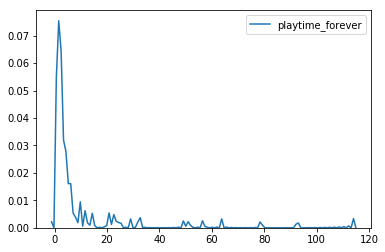

In [47]:
# the density of playtime_forever

sns.kdeplot(train['playtime_forever'])

# We can see that this dataset is imbalance

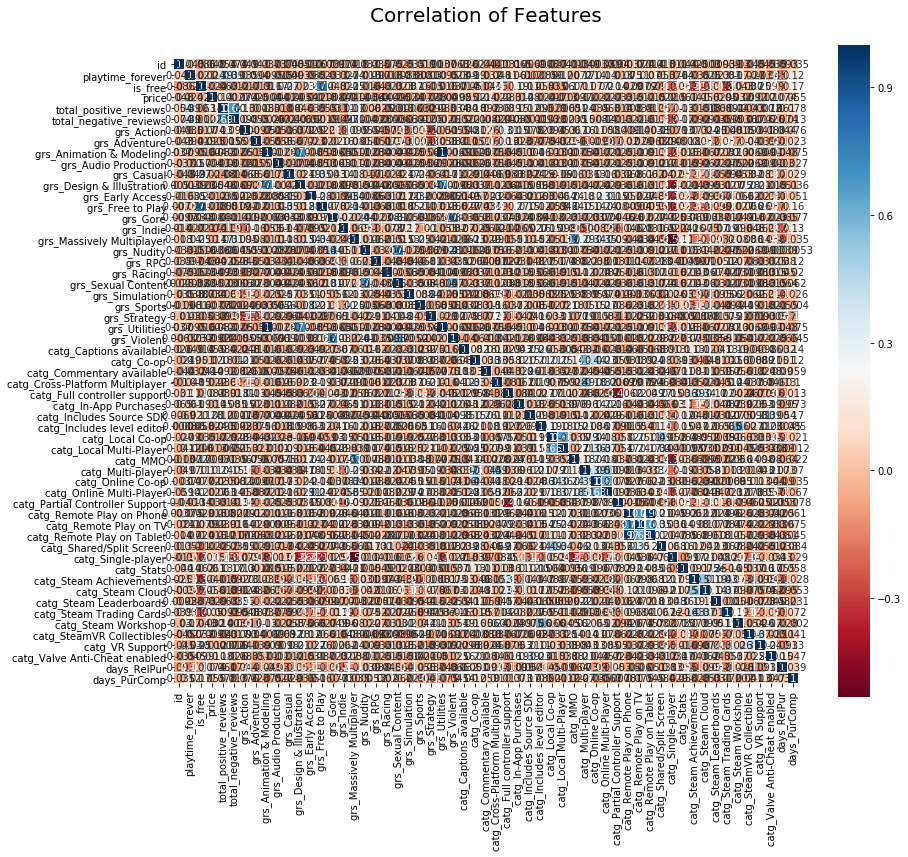

In [48]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=20)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [49]:
train.head(10)

,id,playtime_forever,is_free,price,total_positive_reviews,total_negative_reviews,grs_Action,grs_Adventure,grs_Animation & Modeling,grs_Audio Production,...,catg_Steam Achievements,catg_Steam Cloud,catg_Steam Leaderboards,catg_Steam Trading Cards,catg_Steam Workshop,catg_SteamVR Collectibles,catg_VR Support,catg_Valve Anti-Cheat enabled,days_RelPur,days_PurComp
0,0,0.000000,0,3700.0,372.0,96.0,0,1,0,0,...,0,1,0,1,0,0,0,0,1665,455.0
1,1,0.016667,1,0.0,23.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,472,1038.0
2,2,0.000000,0,5000.0,3018.0,663.0,0,1,0,0,...,0,1,0,1,0,0,0,0,1616,455.0
3,3,1.533333,0,9900.0,63078.0,1746.0,1,0,0,0,...,1,0,0,1,1,0,0,0,2434,1036.0
4,4,22.333333,0,4800.0,8841.0,523.0,1,0,0,0,...,1,1,1,1,0,0,0,0,2043,575.0
5,5,2.933333,0,25800.0,0.0,0.0,0,0,0,0,...,1,0,0,1,0,0,0,0,1006,547.0
6,6,2.616667,0,3600.0,39776.0,1035.0,1,0,0,0,...,1,0,0,1,0,0,0,0,1942,591.0
7,7,0.150000,1,0.0,33.0,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,641,609.0
8,8,0.016667,0,4000.0,1875.0,39.0,0,1,0,0,...,1,1,0,1,0,0,0,0,1732,311.0
9,9,0.016667,0,8800.0,47.0,11.0,1,1,0,0,...,1,1,0,0,0,1,0,0,66,647.0


## 5. training & testing data split

In [56]:
X = train.drop(['is_free','playtime_forever'], axis=1)
Y = train['playtime_forever']

In [57]:
X.shape

(357, 55)

In [58]:
X.head()

,id,price,total_positive_reviews,total_negative_reviews,grs_Action,grs_Adventure,grs_Animation & Modeling,grs_Audio Production,grs_Casual,grs_Design & Illustration,...,catg_Steam Achievements,catg_Steam Cloud,catg_Steam Leaderboards,catg_Steam Trading Cards,catg_Steam Workshop,catg_SteamVR Collectibles,catg_VR Support,catg_Valve Anti-Cheat enabled,days_RelPur,days_PurComp
0,0,3700.0,372.0,96.0,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,1665,455.0
1,1,0.0,23.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,472,1038.0
2,2,5000.0,3018.0,663.0,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,1616,455.0
3,3,9900.0,63078.0,1746.0,1,0,0,0,0,0,...,1,0,0,1,1,0,0,0,2434,1036.0
4,4,4800.0,8841.0,523.0,1,0,0,0,0,0,...,1,1,1,1,0,0,0,0,2043,575.0


In [59]:
Y.shape

(357,)

In [152]:
Y.head()

0     0.000000
1     0.016667
2     0.000000
3     1.533333
4    22.333333
Name: playtime_forever, dtype: float64

In [60]:
# seperate dataframe "train" into training and testing data

Xtrain,Xtest,Ytrain,Ytest = TTS(X,Y,test_size=0.2,random_state=420)

 random forest

In [75]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(Xtrain, Ytrain);

In [76]:
# Use the forest's predict method on the test data
predictions = rf.predict(Xtest)
# Calculate the absolute errors
errors = abs(predictions - Ytest)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.18 degrees.


In [77]:
rf.predict(Xtest)

array([ 0.06485   ,  2.01065   ,  2.4645    ,  0.20325   ,  2.50975   ,
        0.06916667,  6.39228333,  0.55056667,  0.64568333,  1.82795   ,
        0.68225   ,  0.08221667,  0.06798333,  1.95693333,  4.3243    ,
        0.97305   ,  4.56641667,  0.1895    ,  0.17108333,  0.64915   ,
        0.83608333,  1.35973333,  5.87551667,  0.12845   ,  1.7815    ,
        5.01061667,  0.51448333,  1.93136667,  3.50448333,  2.69543333,
        5.35485   ,  1.56865   ,  0.3868    ,  6.54965   , 18.36626667,
        5.38475   ,  0.16331667,  3.96706667,  0.14015   ,  6.09481667,
        0.73208333,  1.50706667,  0.60943333, 13.00568333,  0.10785   ,
        7.85195   ,  0.02723333,  0.33498333,  2.43293333,  2.35398333,
        7.45123333,  1.26425   ,  0.21113333,  1.0418    ,  0.65006667,
        3.4971    ,  0.73176667,  0.47163333,  1.20006667,  0.29325   ,
        0.14656667,  0.2938    ,  0.45225   ,  0.6051    ,  0.17625   ,
        2.0622    ,  0.31881667,  1.16661667,  1.3629    ,  1.23

In [78]:
from math import sqrt
RMSE1 = sqrt(MSE(Ytest,rf.predict(Xtest)))
print(RMSE1)

8.603730321473872


In [79]:
# training
reg = XGBR(n_estimators=100).fit(Xtrain,Ytrain) 

[21:44:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [80]:
order = Xtrain.columns.values.tolist()

In [81]:
test = test[order]

In [82]:
test_predict = rf.predict(test)
test_predict = [y if y > 0 else 0  for y in test_predict]

In [83]:
addr3 = "/Users/shongmatsuzai/Desktop/HKUST-2019fall/MSBD5001/Kaggle-InClass Prediction Competition/data/samplesubmission.csv"
submission = pd.read_csv(addr3)

In [84]:
submission["playtime_forever"] = test_predict

In [85]:
submission.head()

,id,playtime_forever
0,0,4.088233
1,1,6.239183
2,2,4.225683
3,3,7.010283
4,4,11.412750


In [87]:
submission.to_csv("samplesubmission-rf.csv", index=False)

xgboost

In [101]:
reg = XGBR(n_estimators=100).fit(Xtrain,Ytrain) #训练

[21:50:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [102]:
reg.predict(Xtest)

array([-0.28566748,  1.7432477 ,  2.0636578 , -0.17026633,  2.1728427 ,
        0.505168  ,  5.649644  ,  0.18813592,  0.31469923,  0.6098042 ,
        0.9966425 , -0.30982167,  0.42653972,  0.6915758 ,  1.2173463 ,
        0.51387554,  5.0370073 ,  0.67807084, -0.1649692 ,  2.0242157 ,
        0.10520095,  1.8394337 ,  4.829683  , -0.10329074,  0.32601416,
        6.9655313 ,  0.5780775 ,  1.6009954 , -0.71320534,  0.33053064,
        3.4828157 ,  1.3180964 ,  0.6399731 ,  6.571157  , 21.759243  ,
        3.8590038 ,  0.3606584 ,  2.1137662 ,  0.04655495,  2.6974874 ,
        0.7731204 ,  0.26702154,  0.6011111 ,  1.658082  ,  0.06296894,
       13.810682  , -0.43683434,  0.47555697,  1.2694776 ,  1.5470878 ,
        5.141662  ,  0.42013633,  0.6303829 ,  1.304433  ,  0.63812673,
        6.223724  ,  1.7731711 ,  0.43079352,  1.4560953 ,  0.67258734,
        0.3324625 , -0.1648109 ,  0.7808273 ,  0.44234297,  0.06768188,
       -0.24859732,  0.5479043 ,  1.2409493 ,  1.5923793 ,  1.59

In [103]:
# Returns the coefficient of determination R^2 of the prediction.
reg.score(Xtest,Ytest)

-0.010207982960186435

In [104]:
# Mean squared error regression loss
MSE(Ytest,reg.predict(Xtest))

80.76502916879654

In [105]:
from math import sqrt
RMSE = sqrt(MSE(Ytest,reg.predict(Xtest)))
print(RMSE)

8.986936584220262


In [106]:
Y.mean()

3.1192343604108297

In [107]:
test_predict1 = reg.predict(test)
test_predict1 = [y if y > 0 else 0  for y in test_predict1]

In [108]:
addr3 = "/Users/shongmatsuzai/Desktop/HKUST-2019fall/MSBD5001/Kaggle-InClass Prediction Competition/data/samplesubmission.csv"
submission1 = pd.read_csv(addr3)

In [109]:
submission1["playtime_forever"] = test_predict1

In [110]:
submission1.head()

,id,playtime_forever
0,0,1.378261
1,1,1.361409
2,2,0.657495
3,3,2.990633
4,4,15.796722


In [111]:
submission1.to_csv("samplesubmission-xgbr.csv", index=False)